In [1]:
%matplotlib inline
%config InlineBackend.close_figures = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from collections import deque
import random
import yfinance as yf
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import os
import datetime
import time
import logging
logging.getLogger().setLevel(logging.WARNING)
# read graph
import cv2
from PIL import Image

# import my technical package
from technical_indicator import technical_indicator

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Hyperparameter

In [2]:
learning_rate = 1e-4
batch_size = 32
holding_period = 20
info_period = 40
risk_free_rate = 0.05 / (250/holding_period)
gamma = np.exp(-risk_free_rate)
frame_size = 128
num_episodes = 200
friction = 0.005
company_ticker = ['AAPL', 'INTC', 'JPM', 'AEP', 'NKE', 'NVDA', 'MSFT', 'T', 'SBUX', 'GS']
BUY_DATE = '2000-01-01'
end_date = '2016-12-31'

## Environment

In [3]:
class Environment:
    def __init__(self, ticker, friction = friction, frame_size = frame_size, holding_period = holding_period, info_period = info_period, max_steps = 100, end_date = end_date, risk_free_rate = risk_free_rate, device = 'cuda'):
        """
        end_date: YYYY-MM-DD
        """
        self.ticker = ticker
        self.frame_size = frame_size
        self.holding_period = holding_period
        self.info_period = info_period
        self.max_steps = max_steps
        self.risk_free_rate = risk_free_rate
        self.friction = friction
        # buy, sell, do nothing
        self.action_size = 3
        self.reward = 0
        self.done = False
        self.count = 0
        self.ti = technical_indicator("./training_data")
        self.end_date = datetime.datetime(int(end_date.split('-')[0]), int(end_date.split('-')[1]), int(end_date.split('-')[2]))
        self.action_dict = {0: -1, 1: 0, 2: 1}
        self.device = device
        if not os.path.isdir(f'./training_data'):
            os.mkdir(f'./training_data')
            
    def step(self, action):
        
        self.buy_date = min(self.buy_date + datetime.timedelta(self.holding_period), self.end_date)
        start_info_date = self.buy_date - datetime.timedelta(self.info_period)
        start_info_date = f"{start_info_date.year}-{start_info_date.month}-{start_info_date.day}"
        buy_date = f"{self.buy_date.year}-{self.buy_date.month}-{self.buy_date.day}"
        new_price = self.ti.MA_graph(company_id = self._ticker, short_term = 5, long_term = 10, start = start_info_date, end = buy_date)
        
        if new_price == None:
            return 0, 0, 0, 0, True
        
        # Read image data
        desired_size = (self.frame_size, self.frame_size)
        img = cv2.imread(f"./training_data/{self._ticker}_{start_info_date}_{buy_date}.png")
        img_resized = cv2.resize(img, desired_size)
        next_state = np.array(img_resized)
        #next_state = torch.tensor(next_state, dtype = torch.float32).unsqueeze(dim = 0).to(self.device)
        #next_state = next_state.permute(0, 3, 1, 2)
        
        r = (new_price - self.price)/self.price
        self.reward = (r * self.action_dict[action]) * 100
        
        # if do nothing
        if self.action_dict[action] == 0:
            if abs(r) > self.friction:
                # if agent does nothing while the market changes drastically, give some penalty.
                self.reward = -5
            else:
                # if the reason that agent does nothing is because of the market friction, give some reward.
                self.reward = 5
        self.count += 1
        self.price = new_price
        
        if (self.buy_date >= self.end_date) or (self.count >= self.max_steps):
            self.done = True
        
        return next_state, self.reward, self.done, self.buy_date, False
            
        
    def reset(self, buy_date):
        self._ticker = np.random.choice(self.ticker)
        self.count = 0
        self.reward = 0
        self.buy_date = datetime.datetime(int(buy_date.split('-')[0]), int(buy_date.split('-')[1]), int(buy_date.split('-')[2]))
        start_info_date = self.buy_date - datetime.timedelta(self.info_period)
        start_info_date = f"{start_info_date.year}-{start_info_date.month}-{start_info_date.day}"
        
        self.done = False
        self.price = self.ti.MA_graph(company_id = self._ticker, short_term = 5, long_term = 10, start = start_info_date, end = buy_date)
        while self.price == None:
            self._ticker = np.random.choice(self.ticker)
            self.price = self.ti.MA_graph(company_id = self._ticker, short_term = 5, long_term = 10, start = start_info_date, end = buy_date)

        # Read image data
        desired_size = (self.frame_size, self.frame_size)
        img = cv2.imread(f"./training_data/{self._ticker}_{start_info_date}_{buy_date}.png")
        
        img_resized = cv2.resize(img, desired_size)
        state = np.array(img_resized)
        #state = torch.tensor(state, dtype = torch.float32).unsqueeze(dim = 0).to(self.device)
        #state = state.permute(0, 3, 1, 2)
        return state, self.done

In [4]:
class DQLCNN(nn.Module):
    def __init__(self, output_size, frame_size):
        super().__init__()
        """
        states size: factor size x assets x window
        in_channel: factor_size, which is the number of factors
        assets: number of assets
        window: time
        """
        self.output_size = output_size
        self.frame_size = frame_size
        self.convlayers = nn.Sequential(
            # batchsize x 3 x frame_size x frame_size
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(num_features = 8),
            nn.ReLU(),
            
            # batchsize x 8 x frame_size x frame_size
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(num_features = 16),
            nn.ReLU(),
            # -------------------------------------------------------
            nn.MaxPool2d(kernel_size = 2, stride = 2), 
            
            # batchsize x 16 x int(frame_size/2) x int(frame_size/2)
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            
            # batchsize x 32 x int(frame_size/2) x int(frame_size/2)
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            # -------------------------------------------------------
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # batchsize x 64 x int(frame_size/4) x int(frame_size/4)
            nn.Flatten()
        )
        
        self.fclayers = nn.Sequential(
            nn.Linear(in_features = 64 * int(self.frame_size/4) * int(self.frame_size/4), out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = self.output_size),
        )
    
    def forward(self, x):
        x = self.fclayers(self.convlayers(x))
        return x

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

In [6]:
class DQLAgent:
    def __init__(self, action_size, frame_size, gamma, lr, bufferlen = 10000, device = 'cuda'):
        import copy

        self.action_size = action_size
        self.frame_size = frame_size
        self.replay_buffer = ReplayBuffer(bufferlen)
        self.dqlcnn = DQLCNN(self.action_size, self.frame_size).to(device)
        self.dqlcnn_target = DQLCNN(self.action_size, self.frame_size).to(device)
        self.dqlcnn_target.load_state_dict(self.dqlcnn.state_dict())
        self.dqlcnn_optimizer = torch.optim.Adam(self.dqlcnn.parameters(), lr)
        self.gamma = gamma
        self.device = device
        self.criterion = nn.MSELoss()

    def act(self, state, epsilon = 0.01):
        
        if np.random.uniform(0, 1, 1)[0] > epsilon:    
            with torch.no_grad():
                state = torch.tensor(state, dtype = torch.float32).unsqueeze(dim = 0).to(self.device)
                state = state.permute(0, 3, 1, 2)
                action = np.argmax(self.dqlcnn(state).cpu().detach().numpy())
        else:
            action = np.random.randint(0, 3, 1)[0]
        
        return action
    
    def update_model(self, batch_size, tau = 0.1):
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        rewards = torch.tensor(rewards, dtype = torch.float32, requires_grad = True).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        
        states = states.permute(0, 3, 1, 2)
        next_states = next_states.permute(0, 3, 1, 2)
        
        self.dqlcnn.train()
        current_q_values = self.dqlcnn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.dqlcnn_target(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = self.criterion(current_q_values, expected_q_values)
        
        self.dqlcnn_optimizer.zero_grad()
        critic_loss.backward()
        self.dqlcnn_optimizer.step()
        
        # Update Targets
        for param, target_param in zip(self.dqlcnn.parameters(), self.dqlcnn_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        return current_q_values.mean(), next_q_values.mean(), rewards.mean(), critic_loss
    
    def save_network(self, path = './'):
        date = time.ctime(time.time())[:10].replace(' ', '')
        torch.save(agent.dqlcnn.state_dict(), path + f'agent_dqlcnn_{date}.pth')
    
    def load_network(self, filename, path = './'):
        self.dqlcnn.load_state_dict(torch.load(path + filename))

'Episode: [199 / 200], Average Q value: 173.0733, Average Loss: [92.90236733]'

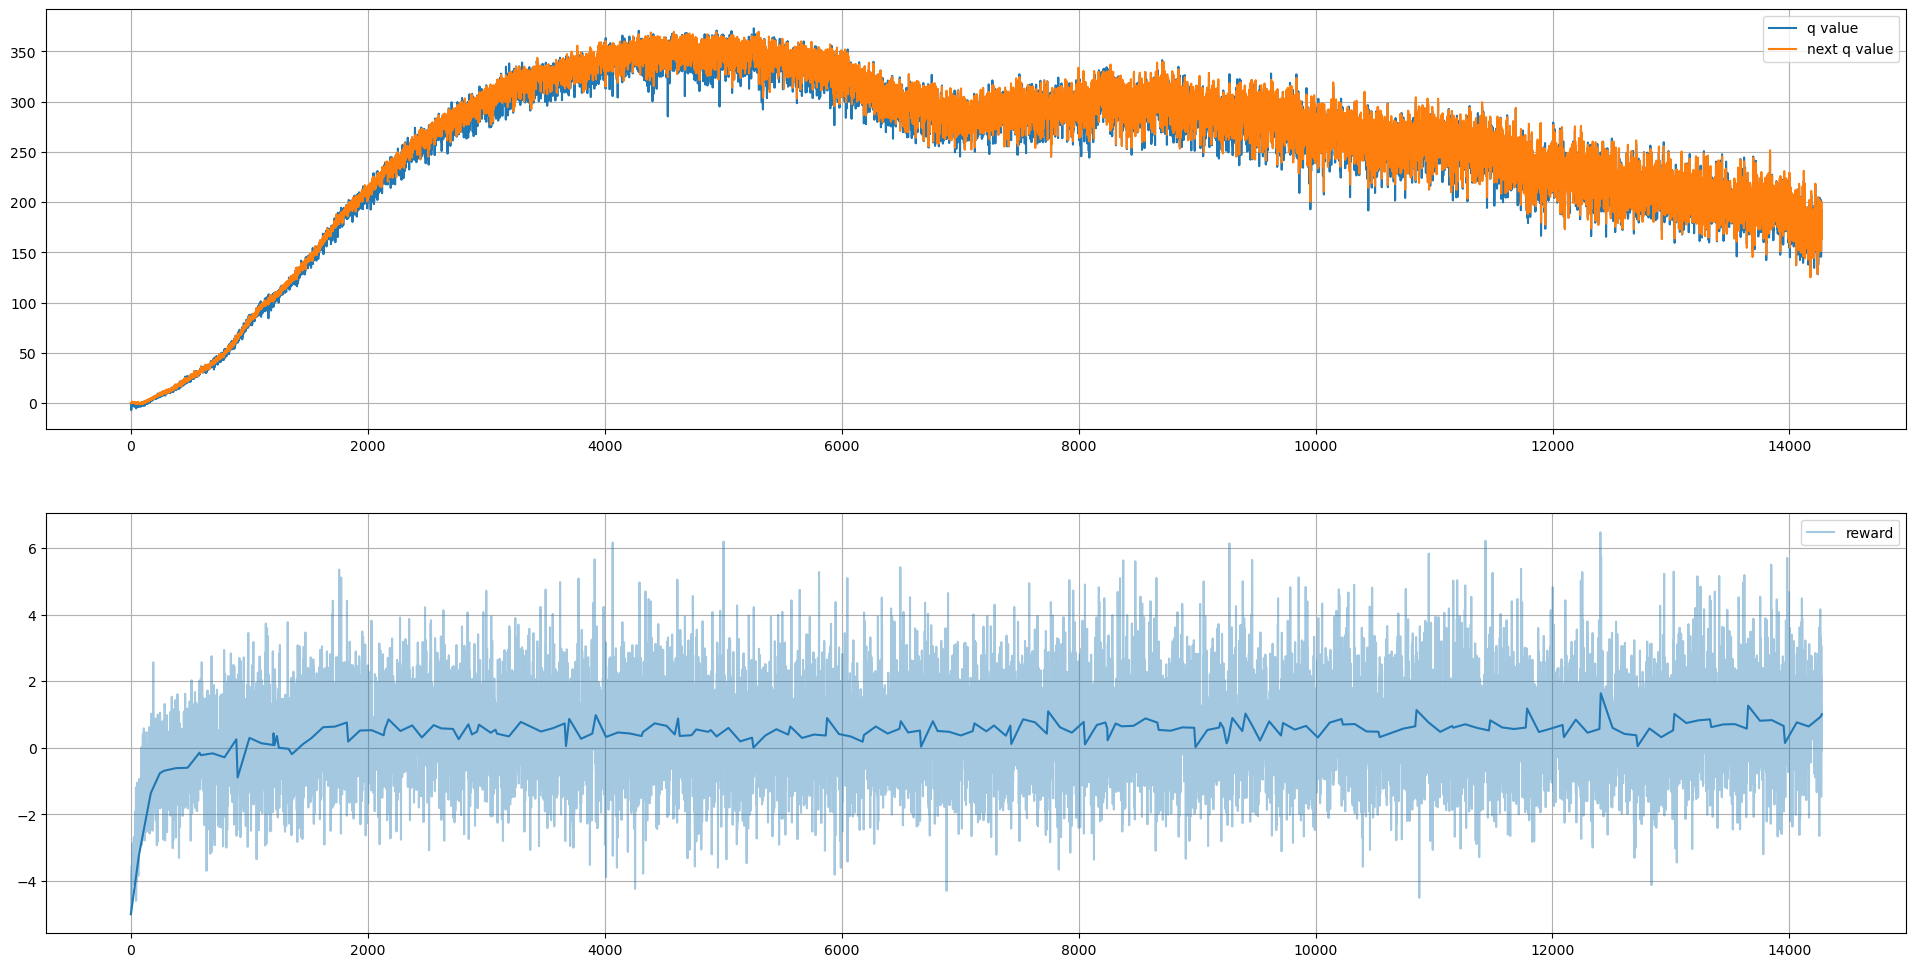

In [7]:
env = Environment(company_ticker)
action_size = env.action_size
agent = DQLAgent(action_size, frame_size, gamma = gamma, lr = learning_rate)

Qvalue = []
nextQvalue = []
rewards = []
reward_mean = []
count_time = [0]
Loss = []
last_average_qvalue = 10000
converge_num = 0

for episode in range(0, num_episodes):
    state, done = env.reset(buy_date = BUY_DATE)
    total_qvalue = 0
    next_total_qvalue = 0
    total_reward = 0
    count = 0
    total_loss = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, buy_date, error = env.step(action)
        if error == 1:
            print("Download Error")
            break
        agent.replay_buffer.push(state, action, reward, next_state, done)
        
        if len(agent.replay_buffer.buffer) > batch_size:
            qvalue, next_qvalue, avgreward, loss = agent.update_model(batch_size)
            total_qvalue += qvalue.item()
            total_loss += loss.item()
            total_reward += avgreward.item()
            Qvalue.append(qvalue.item())
            nextQvalue.append(next_qvalue.item())
            rewards.append(avgreward.item())
            if len(reward_mean) == 0:
                reward_mean.append(avgreward.item())
            count += 1
            
        state = next_state
        BUY_DATE = f"{buy_date.year}-{buy_date.month}-{buy_date.day}"
    
    reward_mean.append(total_reward/count)
    count_time.append(count_time[-1]+count)
    if datetime.datetime(int(BUY_DATE.split('-')[0]), int(BUY_DATE.split('-')[1]), int(BUY_DATE.split('-')[2])) >= datetime.datetime(int(end_date.split('-')[0]), int(end_date.split('-')[1]), int(end_date.split('-')[2])):
        BUY_DATE = '2000-01-01'
    
    if count > 0:
        Loss.append(total_loss/count)
        if episode % 1 == 0:
            %matplotlib inline
            %config InlineBackend.close_figures = True
            clear_output(wait = True)
            display(f"Episode: [{episode} / {num_episodes}], Average Q value: {round(total_qvalue/count, 4)}, Average Loss: {np.array(Loss[-1: ])}")
            plt.figure(figsize = (24, 12))
            plt.subplot(211)
            plt.plot(Qvalue, label = 'q value')
            plt.plot(nextQvalue, label = 'next q value')
            plt.grid(True)
            plt.legend()
            plt.subplot(212)
            plt.plot(rewards, label = 'reward', alpha = 0.4, color = 'tab:blue')
            plt.plot(count_time, reward_mean, color = 'tab:blue')
            plt.legend()
            plt.grid(True)
            plt.show()
            %matplotlib inline
            %config InlineBackend.close_figures = False
    else:
        episode -= 1
agent.save_network()

## Load Agent

In [23]:
#agent = DQLAgent(3, frame_size, gamma = gamma, lr = learning_rate)
#agent.load_network('agent_dqlcnn_WedDec13.pth')

In [8]:
class Playground:
    def __init__(self, ticker, start, holding_period, info_period, frame_size, agent, friction = friction):
        self.ticker = ticker
        self.start = start
        self.start_ = start
        self.real_start = start
        self.holding_period = holding_period
        self.info_period = info_period
        self.position = [0]
        self.count = 0
        self.correct = 0
        self.wrong = 0
        self.frame_size = frame_size
        self.agent = agent
        self.friction = friction
        self.buy = 0
        self.sell = 0
        self.return_ = [0]
        self.action_dict = {0: -1, 1: 0, 2: 1}
        self.correct_return = 0
        self.wrong_return = 0
        self.date = [pd.to_datetime(self.start)]
        self.position_date = [pd.to_datetime(self.start)]
        
    def play(self):
        if not os.path.isdir(f'./{self.ticker}_{self.start}'):
            os.mkdir(f'./{self.ticker}_{self.start}')
        ti = technical_indicator(f'./{self.ticker}_{self.start}')
        
        while True:
            
            data_start = datetime.datetime(int(self.start.split('-')[0]), int(self.start.split('-')[1]), int(self.start.split('-')[2]))
            data_end = data_start + datetime.timedelta(self.info_period)
            end = f"{data_end.year}-{data_end.month}-{data_end.day}"
            
            if data_start > datetime.datetime.now():
                break
                
            _ = ti.MA_graph(company_id = self.ticker, short_term = 5, long_term = 10, start = self.start, end = end)
            if _ == None:
                next_start = data_end + datetime.timedelta(self.holding_period) - datetime.timedelta(self.info_period)
                next_start = f"{next_start.year}-{next_start.month}-{next_start.day}"
                self.start = next_start
                continue
            desired_size = (self.frame_size, self.frame_size)
            img = cv2.imread(f"./{self.ticker}_{self.real_start}/{self.ticker}_{self.start}_{end}.png")
            img_resized = cv2.resize(img, desired_size)
            state = np.array(img_resized)
            
            action = self.agent.act(state)
            price = yf.download(self.ticker, start = data_end, end = data_end + datetime.timedelta(self.holding_period), progress = False)
            if price.shape[0] == 0:
                next_start = data_end + datetime.timedelta(self.holding_period) - datetime.timedelta(self.info_period)
                next_start = f"{next_start.year}-{next_start.month}-{next_start.day}"
                self.start = next_start
                continue
                
            self.position.append(self.action_dict[action])
            self.position.append(-self.action_dict[action])
            self.date.append(price.index[0])
            self.position_date.append(price.index[0])
            self.position_date.append(price.index[-1])
            
            next_start = data_end + datetime.timedelta(self.holding_period) - datetime.timedelta(self.info_period)
            next_start = f"{next_start.year}-{next_start.month}-{next_start.day}"
            self.start = next_start
            
            Return = (price.Close.iloc[-1] - price.Close.iloc[0])/price.Close.iloc[0]
            if Return * self.action_dict[action] > 0:
                self.correct += 1
                self.correct_return += Return * self.action_dict[action]
            elif self.action_dict[action] == 0:
                if abs(Return) < self.friction:
                    self.correct += 1
                else:
                    self.wrong += 1
            else:
                self.wrong += 1
                self.wrong_return += Return * self.action_dict[action]
                
            if action.item() == 2:
                self.buy += 1
            if action.item() == 0:
                self.sell += 1
            self.count += 1
            self.return_.append(Return * self.action_dict[action])
            
            
    def info(self):
        %matplotlib inline
        %config InlineBackend.close_figures = True
        self.position = pd.DataFrame({'class': self.position})
        self.position.index = self.position_date
        while True:
            p = yf.download(self.ticker, start = self.start_).Close
            if p.shape != 0:
                price = p
                break
        buy_hold_return = price.pct_change()
        buy_hold_return.iloc[0] = 0
        buy_hold_return = buy_hold_return.cumsum()
        
        index = price.index.to_numpy()
        index[0] = self.position_date[0]
        self.position['price'] = price.loc[self.position_date]
        
        print(f"Start from {self.real_start} to {self.start}")
        print(f"Win rate: {round(self.correct/self.count, 4)}")
        print(f"Correct average price diff: {round(self.correct_return/self.correct, 4)}")
        print(f"Wrong average price diff: {round(self.wrong_return/self.wrong, 4)}")
        plt.figure(figsize = (24, 12))
        plt.title(f"{self.ticker} accuracy rate: {round(self.correct/self.count, 4)}")
        plt.subplot(211)
        plt.grid(True)
        plt.plot(self.date, np.cumsum(np.array(self.return_)), label = 'agent')
        plt.plot(buy_hold_return, label = 'buy and hold')
        plt.legend()
        class_styles = {
                            1: {'color': 'red', 'marker': '^'},  
                            -1: {'color': 'green', 'marker': 'v'},  
                            0: {'color': 'gray', 'marker': 'o'},  
                       }
        plt.subplot(212)
        plt.title(f"Correct avg diff: {round(self.correct_return/self.correct, 2)}, Wrong avg diff: {round(self.wrong_return/self.wrong, 2)}")
        plt.grid(True)
        plt.plot(price)
        for cls, style in class_styles.items():
            class_data = self.position[self.position['class'] == cls]
            plt.scatter(class_data.index, class_data.price, color=style['color'], marker=style['marker'])
        date = time.ctime(time.time())[:10].replace(' ', '')
        plt.savefig(f"{self.ticker}_PnL_{date}.png")
        plt.show()
        %matplotlib inline
        %config InlineBackend.close_figures = False


1 Failed download:
- 2881.TW: Data doesn't exist for startDate = 1702656000, endDate = 1704384000

1 Failed download:
- 2881.TW: Data doesn't exist for startDate = 1704384000, endDate = 1706112000
[*********************100%***********************]  1 of 1 completed
Start from 2017-01-01 to 2023-12-16
Win rate: 0.52
Correct average price diff: 0.0313
Wrong average price diff: -0.0203


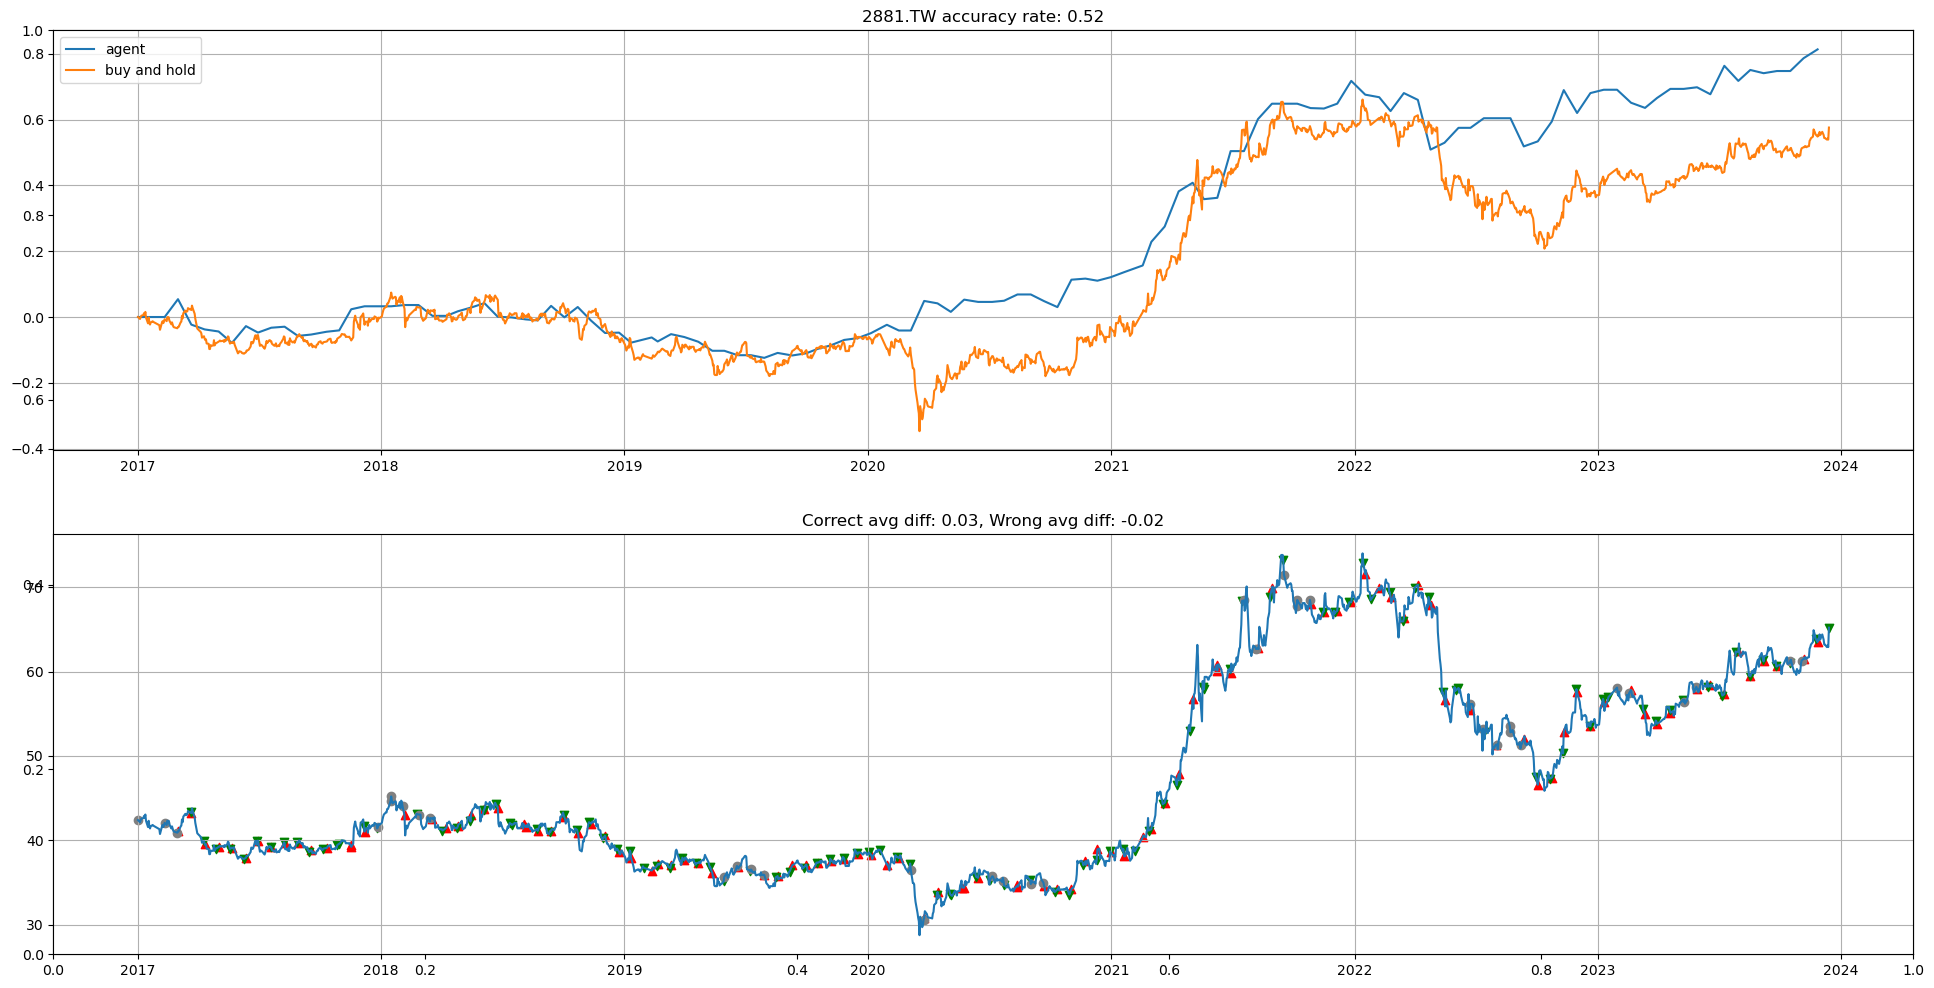

In [14]:
playground = Playground('2881.TW', start = '2017-01-01', holding_period = 20, info_period = info_period, frame_size = frame_size, agent = agent)
playground.play()
playground.info()